# Lookup Table PSF

Make derive the wavelength-dependent PSF from a fixed-slit observation of a bright standard star.

Implemented in [PR #82](https://github.com/gbrammer/msaexp/pull/82).

In [1]:
import msaexp.spectrum
import glob
from scipy.stats import binned_statistic
from msaexp.resample_numba import pixel_integrated_gaussian_numba as PRF

import mastquery.jwst, mastquery.utils
import msaexp.spectrum
import msaexp.utils as msautils
import os
import glob

import numpy as np
from grizli.aws import db
from grizli import utils
import matplotlib.pyplot as plt

from msaexp.resample_numba import pixel_integrated_gaussian_numba as PRF
from scipy.stats import binned_statistic

import jwst.datamodels
from scipy.optimize import minimize, nnls

import scipy.optimize

Set ROOT_PATH=/usr/local/share/python/msaexp/docs/examples


## Read spectrum and pixel table

PRISM spectrum of P330E in the wide S1600 fixed slit from CAL-1538.

In [2]:
# Files added to https://github.com/gbrammer/msaexp/pull/82
ptab_file = 'https://github.com/user-attachments/files/17609875/fs_1538_prism-clear_p330e_s1600a1.pixtab.fits.gz'
spe_file = 'https://github.com/user-attachments/files/17609879/fs_1538_prism-clear_p330e_s1600a1.spec.fits.gz'

# Local files
path = '/Users/gbrammer/Research/JWST/Projects/NIRSpec/cal-iras05248/Wavecal2024/'
ptab_file = path + 'fs_1487_prism-clear_1743045_s200a1.pixtab.fits'

# ptab_file = path + 'fs_1487_g140m-f100lp_1743045_s200a1.pixtab.fits'

# ptab_file = path + 'fs_4460_prism-clear_1743045_s200a1.pixtab.fits'
# ptab_file = path + 'fs_1128_g140m-f070lp_1808347_s200a1.pixtab.fits'
# ptab_file = path + 'fs_1128_g235m-f170lp_1808347_s200a1.pixtab.fits'
# ptab_file = path + 'fs_1128_g395m-f290lp_1808347_s200a1.pixtab.fits'

# spe_file = ptab_file.replace('pixtab','spec')

# Read them
sp = msaexp.spectrum.SpectrumSampler(spe_file)
ptab = utils.read_catalog(ptab_file, format='fits')

ptab['xint'] = np.interp(ptab['wave'], sp['wave'], np.linspace(0,1,len(sp['wave'])))
bin_wave = sp['wave']
wbins = msautils.array_to_bin_edges(bin_wave)

ptab = ptab[np.abs(ptab['yslit']) < 32]

wlo = sp['wave'][::10]
wlo_edges = msautils.array_to_bin_edges(wlo)

print(ptab.colnames)

# ptab = ptab[ptab['exposure_index'] == 0]
if "mask" in ptab.colnames:
    ptab = ptab[ptab["mask"]]


['sci', 'sky', 'mask', 'var_total', 'var_rnoise', 'wave', 'dwave_dx', 'yslit', 'bar', 'profile', 'pathloss', 'exposure_index', 'exptime', 'xint']


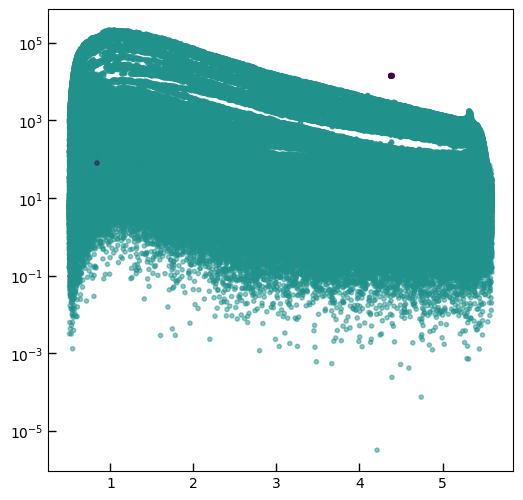

In [3]:
if 'prism' in ptab_file:
    # some bad pixels
    xx = np.abs(ptab['yslit']) < 1
    valid = np.isfinite(ptab['sci'])
    valid[xx & (ptab['wave'] < 2) & (ptab['sci'] < 300)] = False

    valid[~xx & (ptab['wave'] > 4) & (ptab['sci'] > 1e4)] = False

    
    plt.scatter(ptab['wave'], ptab['sci'], c=valid, vmin=0, vmax=2, alpha=0.5)
    plt.semilogy()

    ptab = ptab[valid]

else:
    # some bad pixels
    xx = np.abs(ptab['yslit']) < 1
    # xx = (np.abs(ptab['yslit']) > 0.5) & (np.abs(ptab['yslit']) < 1)

    valid = np.isfinite(ptab['sci'])
    #valid[xx & (ptab['wave'] < 2) & (ptab['sci'] < 300)] = False

    # valid[~xx & (ptab['wave'] > 4) & (ptab['sci'] > 1e4)] = False

    med = binned_statistic(ptab['wave'][xx], ptab['sci'][xx], bins=wlo_edges, statistic='median').statistic
    med_norm = np.interp(ptab['wave'], wlo, med)
    valid[xx & (ptab['sci'] < 0.2*med_norm)] = False

    vmed = binned_statistic(ptab['wave'][xx], np.sqrt(ptab['var_rnoise'])[xx], bins=wlo_edges, statistic='median').statistic
    vmed_norm = np.interp(ptab['wave'], wlo, vmed)
    # valid[xx & (ptab['var_rnoise'] > 2*med_norm)] = False
    valid[(np.sqrt(ptab['var_rnoise']) > 2*vmed_norm)] = False

    # plt.scatter(ptab['wave'][xx], ptab['sci'][xx], c=valid[xx], vmin=0, vmax=2, alpha=0.5)
    plt.scatter(ptab['wave'][xx], ptab['sci'][xx], c=valid[xx], vmin=0, vmax=2, alpha=0.5)
    plt.plot(wlo, med, color='r')
    # plt.plot(wlo, vmed, color='r')
    plt.semilogy()

    # plt.xlim(1, 1.5)
    

    # ptab = ptab[valid]


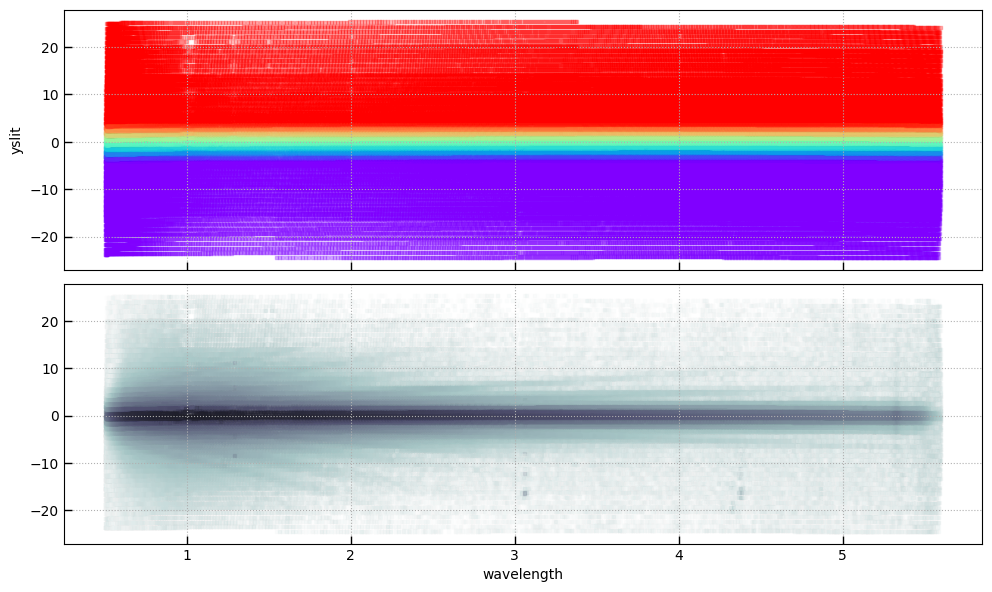

In [4]:
# flat_sky = None

fig, axes = plt.subplots(2,1,figsize=(10,6), sharex=True, sharey=True)

s = 5
axes[0].scatter(ptab['wave'], ptab['yslit'], alpha=0.1, c=ptab['yslit'], vmin=-4, vmax=4, cmap='rainbow', marker='s', s=s)
axes[1].scatter(ptab['wave'], ptab['yslit'], alpha=0.1, c=np.log10(ptab['sci']), cmap='bone_r', marker='s', s=s, vmin=0.1, vmax=6)

axes[0].set_ylabel('yslit')
axes[1].set_xlabel('wavelength')
for ax in axes:
    ax.grid()
    
fig.tight_layout(pad=1)

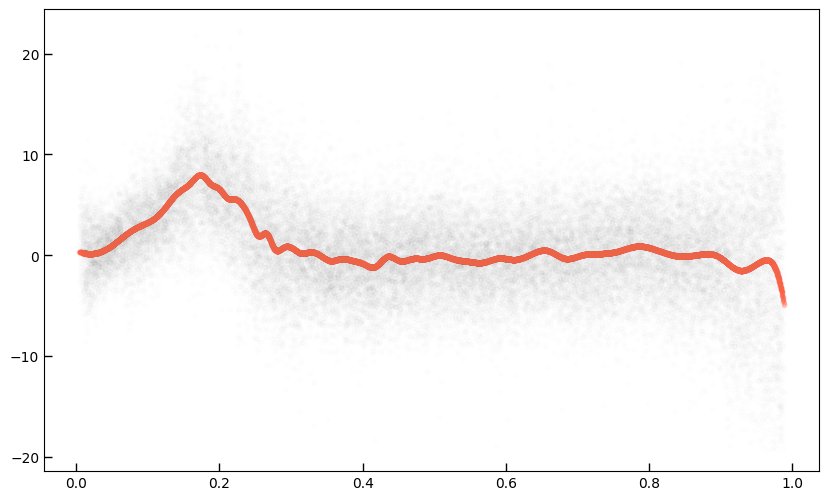

In [5]:
is_sky = np.abs(ptab['yslit']) > 18

sky_bspl = utils.bspline_templates(ptab['wave'], df=51, get_matrix=True)
Ax = (sky_bspl.T / np.sqrt(ptab['var_total'])).T
yx = ptab['sci'] / np.sqrt(ptab['var_total'])

sky_valid = is_sky & True
for _iter in range(3):
    sky_coeffs = np.linalg.lstsq(Ax[is_sky & sky_valid,:], yx[is_sky & sky_valid], rcond=None)
    sky_model = sky_bspl.dot(sky_coeffs[0])
    sky_valid = (np.abs(ptab['sci'] - sky_model) < 20) & (ptab['sci'] > -20)
    if 'g140m' in ptab_file:
        sky_valid &= (np.abs(ptab['sci'] - sky_model) < 20) & (ptab['sci'] < 20)

fig, ax = plt.subplots(1,1,figsize=(10,6), sharex=True, sharey=True)

plt.scatter(ptab['xint'][is_sky & sky_valid], ptab['sci'][is_sky & sky_valid], alpha=0.01, color='0.7')
plt.scatter(ptab['xint'][is_sky & sky_valid], sky_model[is_sky & sky_valid], alpha=0.05, color='tomato')

ptab['sci_clean'] = ptab['sci'] - sky_model

# ptab['sci_clean'] = ptab['sci']*1.

# plt.ylim(-10, 50)
             

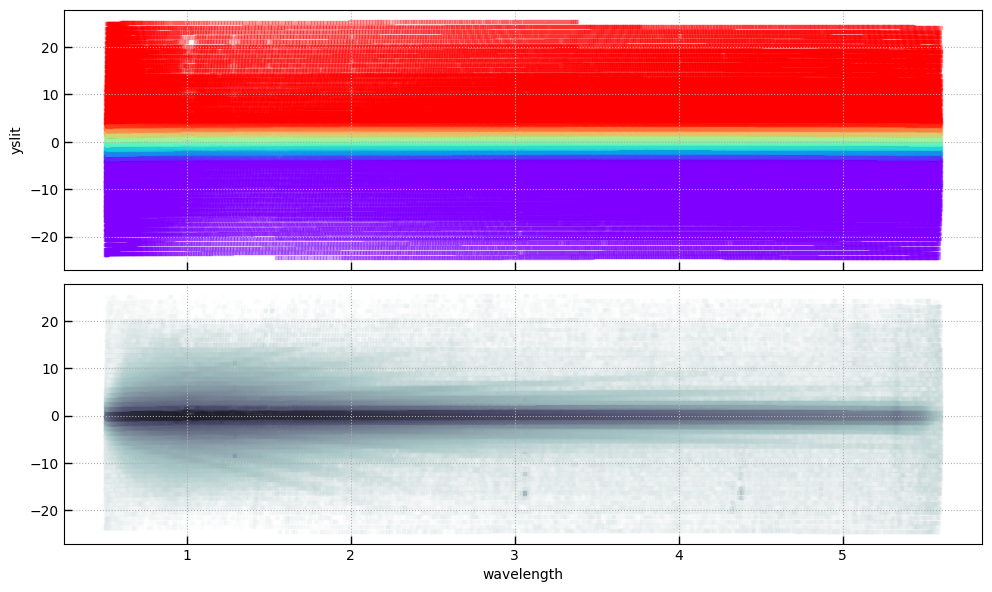

In [6]:
# flat_sky = None

fig, axes = plt.subplots(2,1,figsize=(10,6), sharex=True, sharey=True)

s = 5
axes[0].scatter(ptab['wave'], ptab['yslit'], alpha=0.1, c=ptab['yslit'], vmin=-4, vmax=4, cmap='rainbow', marker='s', s=s)
axes[1].scatter(ptab['wave'], ptab['yslit'], alpha=0.1, c=np.log10(ptab['sci_clean']), cmap='bone_r', marker='s', s=s, vmin=0.1, vmax=6)

axes[0].set_ylabel('yslit')
axes[1].set_xlabel('wavelength')
for ax in axes:
    ax.grid()
    
fig.tight_layout(pad=1)

## Set profile components

Build a flexible profile as a sum of pixel-integrated Gaussians along the trace

In [7]:
trace_shift_coeffs = [0.]

ydx = [0.1, 0.5, 3]
ydx = np.array(ydx)*2
xdx = [0, 10, 30]

yclip = 12.5
yclip = 14.5

ymax = np.minimum(ptab['yslit'].max() - 1, yclip)
# ymax = np.minimum(ymax, np.abs(ptab['yslit'][ptab['bar'] > 0.09]).max())
dx = [0.1, 1.5*ymax/8]


steps = []
step = 0 #dx[0]
scl = 2
while step < ymax:
    steps.append(step)
    dx_i = np.interp(step, xdx, ydx)/scl
    step += dx_i

steps.append(step)
pcenters = np.append(-np.array(steps[1::][::-1]), np.array(steps))
pwidths = np.gradient(pcenters)*scl

undo_bar = 1.0

profs = []
for m, pw in zip(pcenters, pwidths):
    if trace_shift_coeffs is None:
        pi = PRF(ptab['yslit'].astype(float), m, pw, dx=1.)
    else:
        dy = np.polyval(trace_shift_coeffs, ptab['xint'])
        pi = PRF((ptab['yslit'] + dy).astype(float), m, pw, dx=1.)

    profs.append(pi)

profs = np.array(profs)

pw, pcenters

(2.0191592630586293,
 array([-15.08621668, -14.07663705, -13.17923294, -12.38154039,
        -11.67248034, -11.04220475, -10.48195978,  -9.98265363,
         -9.50255157,  -9.04091497,  -8.59703363,  -8.17022464,
         -7.75983138,  -7.36522249,  -6.98579085,  -6.62095274,
         -6.27014687,  -5.93283353,  -5.60849378,  -5.29662863,
         -4.9967583 ,  -4.70842144,  -4.43117446,  -4.16459083,
         -3.90826041,  -3.66178886,  -3.42479698,  -3.19692017,
         -2.97780786,  -2.76712294,  -2.56454129,  -2.36975124,
         -2.18245311,  -2.00235876,  -1.82919112,  -1.66268377,
         -1.50258055,  -1.34863514,  -1.20061071,  -1.05827953,
         -0.92142263,  -0.78982945,  -0.66329755,  -0.54163226,
         -0.4246464 ,  -0.31216   ,  -0.204     ,  -0.1       ,
          0.        ,   0.1       ,   0.204     ,   0.31216   ,
          0.4246464 ,   0.54163226,   0.66329755,   0.78982945,
          0.92142263,   1.05827953,   1.20061071,   1.34863514,
          1.5025805

## Fit profile in independent wavelength bins

In [8]:
spec_norm = np.ones_like(ptab['sci_clean'])

In [9]:
# 32 wavelength steps across prism bandpass

if 'prism' in ptab_file:
    wsteps = np.interp(np.linspace(0,1,32), np.linspace(0,1,len(sp['wave'])), sp['wave'])
    
    wsteps = np.hstack([[0.5, 0.7], np.linspace(0.8, 1.8, 16), np.linspace(1.95, 5.0, 18), [5.2, 5.6, 6]])
    # wsteps = np.interp(wsteps, sp['wave'], np.linspace(0,1,len(sp['wave'])), left=0, right=1)

elif 'f100lp' in ptab_file:
    wsteps = np.hstack([[0.7, 0.85, 0.92, 0.95, 1.0, 1.05], np.linspace(1.15, 1.8, 16), np.linspace(1.95, 3.5, 16)])

elif 'f070lp' in ptab_file:
    # wsteps = np.hstack([[0.7, 0.85, 0.92, 0.95, 1.0, 1.05], np.linspace(1.15, 1.8, 16), np.linspace(1.95, 3.5, 16)])
    wsteps = np.linspace(0.6, 3.3, 32)
    wsteps = np.hstack([np.linspace(0.6, 1.25, 10), [1.3, 1.35], np.linspace(1.4, 3.3, 16)])
elif 'g235m' in ptab_file:
    # wsteps = np.hstack([[0.7, 0.85, 0.92, 0.95, 1.0, 1.05], np.linspace(1.15, 1.8, 16), np.linspace(1.95, 3.5, 16)])
    wsteps = np.linspace(1.5, 5.4, 32)
    wsteps = np.hstack([[1.55, 1.65, 1.75], np.linspace(1.85, 5.4, 32)])

elif 'g395m' in ptab_file:
    # wsteps = np.hstack([[0.7, 0.85, 0.92, 0.95, 1.0, 1.05], np.linspace(1.15, 1.8, 16), np.linspace(1.95, 3.5, 16)])
    wsteps = np.hstack([[2.6, 2.7, 2.8, 3.0], np.linspace(3.1, 6.0, 36)])

else:
    
    wsteps = np.interp(np.linspace(0,1,24), np.linspace(0,1,len(sp['wave'])), sp['wave'])

coeffs = []

wht = 1./(spec_norm * np.sqrt(ptab['var_total']))
wht[~np.isfinite(wht)] = 0
if 'prism' in ptab_file:
    wht[ptab['sci'] > 1.e6] = 0
    wht[ptab['sci'] < 0] = 0

for i, wi in enumerate(wsteps):
    sub = np.abs(ptab['wave'] - wi) <= np.gradient(wsteps)[i]
    # sub &= np.abs(ptab['yslit'] < 10)

    sub &= wht > 0
    print(wi, sub.sum()) #, ptab['wave'][sub].min(), ptab['wave'][sub].max())
    if sub.sum() == 0:
        coeffs.append(np.zeros(profs.shape[0]))
        continue

    
    c = scipy.optimize.nnls((profs[:,sub]*wht[sub]).T, (ptab['sci_clean'] * undo_bar * wht)[sub])

    # print(wi)
    coeffs.append(c[0])

coeffs = np.array(coeffs)
cnorm = (coeffs.T / coeffs.sum(axis=1)).T
N = profs.shape[0]

cw = np.array([np.interp(ptab['wave'], wsteps, coeffs[:,i], left=coeffs[0,i], right=coeffs[-1,i]) for i in range(N)])
cwn = np.array([np.interp(ptab['wave'], wsteps, cnorm[:,i], left=cnorm[0,i], right=cnorm[-1,i]) for i in range(N)])
cprof = (cw*profs).sum(axis=0)
cprofn = (cwn*profs).sum(axis=0)


0.5 26720
0.7 30297
0.8 11269
0.8666666666666667 7446
0.9333333333333333 6293
1.0 5335
1.0666666666666667 4974
1.1333333333333333 4845
1.2000000000000002 4548
1.2666666666666666 4281
1.3333333333333335 4146
1.4 4100
1.4666666666666668 4018
1.5333333333333332 3996
1.6 4064
1.6666666666666667 4152
1.7333333333333334 4165
1.8 6770
1.95 10423
2.1294117647058823 11745
2.3088235294117645 12283
2.488235294117647 12689
2.6676470588235293 12950
2.847058823529412 13208
3.026470588235294 13709
3.2058823529411766 14450
3.385294117647059 14924
3.564705882352941 15388
3.7441176470588236 15872
3.923529411764706 16446
4.102941176470588 17546
4.2823529411764705 18240
4.461764705882353 18578
4.641176470588236 19484
4.820588235294117 20443
5.0 21938
5.2 34426
5.6 21950
6.0 0


### Normalize by average spectrum


2024-11-05 20:14:11,001 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw310-2024/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2024-11-05 20:14:12,366 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw310-2024/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2024-11-05 20:14:13,946 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw310-2024/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2024-11-05 20:14:15,360 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/jw310-2024/lib/python3.10/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(



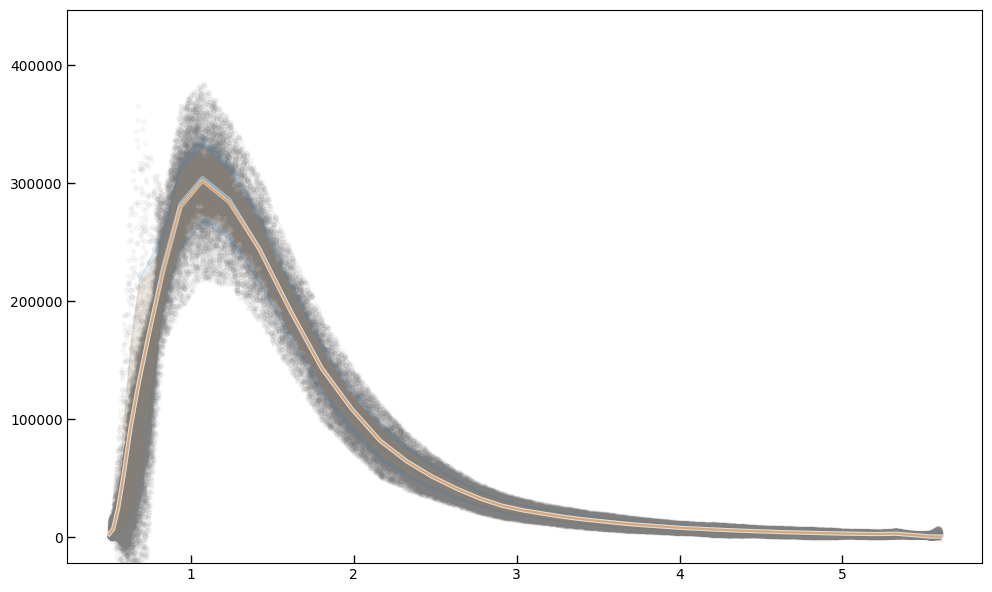

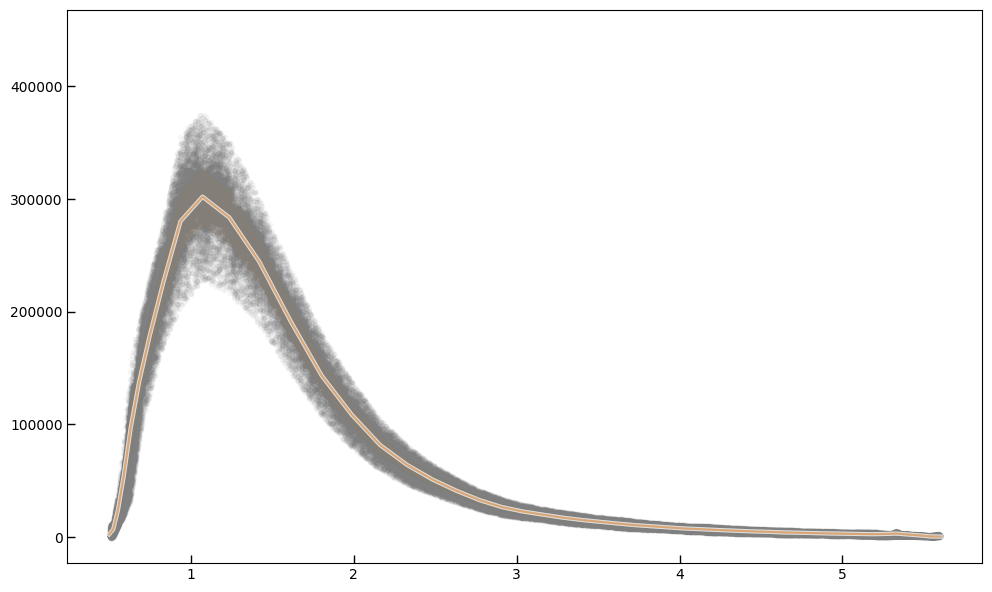

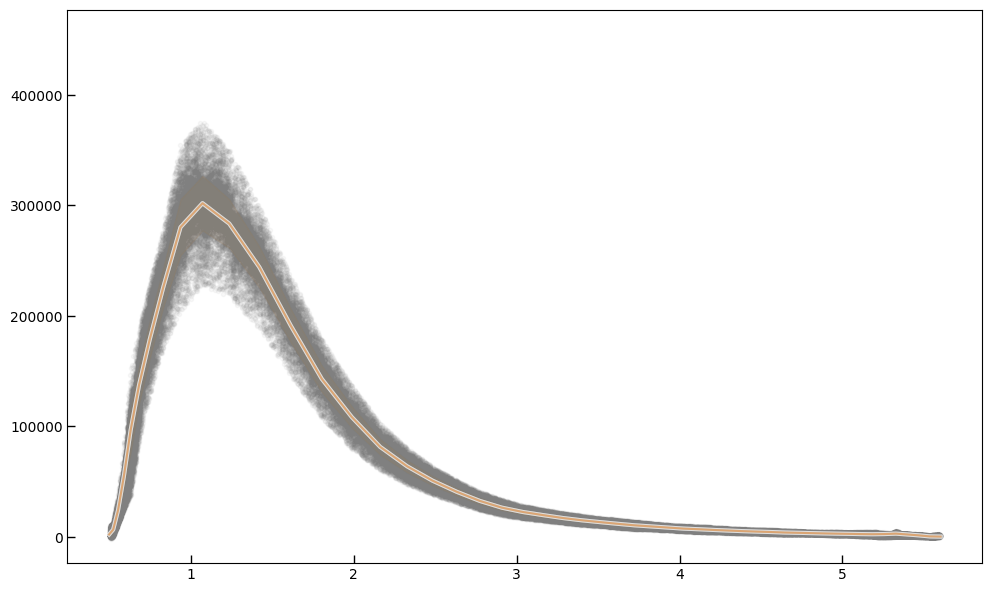

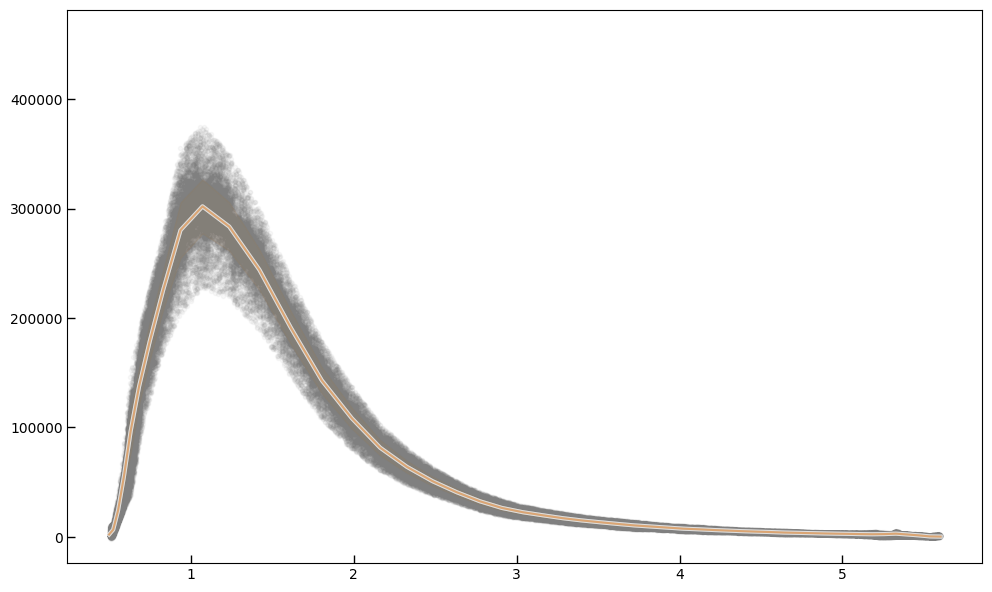

In [10]:
from scipy.stats import binned_statistic
    
mask_inliers = np.isfinite(spec_norm) # & (ptab['sci'] > 10)

if 'prism' in ptab_file:
    threshold = 100
elif 'f070lp' in ptab_file:
    threshold = 100
elif 'g235m' in ptab_file:
    threshold = 100
elif 'g395m' in ptab_file:
    threshold = 100
else:
    threshold = -100
    
for _iter in range(4):

    fig, ax = plt.subplots(1,1,figsize=(10,6), sharex=True, sharey=True)

    for _iter2 in range(2):
        normed = ptab['sci_clean']/cprofn
            
        wht = cprofn**2/ptab['var_total']
        
        wht[~np.isfinite(normed)] = 0
        wht[~mask_inliers] = 0
        wht[ptab['sci']/cprofn < threshold] = 0
        normed[wht == 0] = 0
    
        if 'prism' not in ptab_file:
            wht *= np.abs(ptab['yslit']) < 2.5
        
        bin_num = binned_statistic(ptab['wave'], normed*wht, bins=wlo_edges, statistic='sum')
        bin_den = binned_statistic(ptab['wave'], wht, bins=wlo_edges, statistic='sum')
        binned_spec = bin_num.statistic / bin_den.statistic
    
        # binned_spec = binned_statistic(ptab['wave'][wht > 0], normed[wht > 0], bins=wbins, statistic='median').statistic
        
        spec_norm = np.interp(ptab['wave'], wlo, binned_spec)
    
        nmad = 1.48*binned_statistic(ptab['wave'][wht > 0], np.abs(normed - spec_norm)[wht > 0], bins=wlo_edges, statistic='median').statistic
        nmad_norm = np.interp(ptab['wave'], wlo, nmad)
    
        # med = 1.48*binned_statistic(ptab['wave'][wht > 0], normed[wht > 0], bins=wbins, statistic='median').statistic
        # med_norm = np.interp(ptab['wave'], bin_wave, med)
    
        pl = ax.plot(wlo, binned_spec, color='w', alpha=0.5, lw=3, zorder=100)
        pl = ax.plot(wlo, binned_spec, alpha=0.5, zorder=100)
        ax.fill_between(wlo, binned_spec-nmad, binned_spec+nmad, color=pl[0].get_color(), alpha=0.1)
    
        # mask_inliers = (np.abs(normed - spec_norm) < 0.1e6) & (wht > 0)
        mask_inliers &= (np.abs(normed - spec_norm) < 3*nmad_norm) # & (wht > 0)
        # mask_inliers &= (np.abs(normed - spec_norm) < 5*np.sqrt(ptab['var_total'])/cprofn) & (wht > 0)
        #mask_inliers &= (normed < 3*med_norm) & (normed > med_norm/3)
    
    # ax.set_ylim(-0.1e6, 1.5e6)
    med = np.nanpercentile(normed[mask_inliers & (wht > 0)], 90)
    ax.set_ylim(-0.1*med, 2*med)
    
    ax.scatter(ptab['wave'][mask_inliers & (wht > 0)], normed[mask_inliers & (wht > 0)], alpha=0.05, color='0.5', zorder=-10)
    # ax.semilogy()
    
    # ax.semilogy(); ax.set_ylim(0.01, 1.e6)
    
    fig.tight_layout(pad=1)

    # plt.xlim(1.5, 1.9)
    
    ###############
    ### Fit profile again
    
    coeffs = []
    
    wht = 1./(1 * np.sqrt(ptab['var_total']))
    wht[~np.isfinite(wht)] = 0
    # wht[~mask_inliers] = 0
    wht[ptab['sci']/cprofn < threshold] = 0
    
    for i, wi in enumerate(wsteps):
        sub = np.abs(ptab['wave'] - wi) < np.gradient(wsteps)[i]/2
        # sub &= np.abs(ptab['yslit'] < 10)
    
        sub &= np.isfinite(spec_norm)
        sub &= wht > 0
        
        if sub.sum() == 0:
            coeffs.append(np.zeros(profs.shape[0]))
            continue
    
        
        c = scipy.optimize.nnls((profs[:,sub]*wht[sub]).T, (ptab['sci_clean'] / spec_norm * undo_bar * wht)[sub])
    
        # print(wi)
        coeffs.append(c[0])
    
    coeffs = np.array(coeffs)
    # Fill last bins
    if coeffs[-1,:].sum() == 0:
        coeffs[-1:,:] = coeffs[-2,:]*1

    if coeffs[0,:].sum() == 0:
        coeffs[0,:] = coeffs[1,:]*1

    if 'f100lp' in ptab_file:
        wtrim = np.where(wsteps < 1)[0]
        coeffs[wtrim,:] = coeffs[wtrim[-1]+1,:]*1
    elif 'f070lp' in ptab_file:
        wtrim = np.where(wsteps < 0.7)[0]
        coeffs[wtrim,:] = coeffs[wtrim[-1]+1,:]*1
    elif 'g235m' in ptab_file:
        wtrim = np.where(wsteps < 1.7)[0]
        coeffs[wtrim,:] = coeffs[wtrim[-1]+1,:]*1
    elif 'g395m' in ptab_file:
        wtrim = np.where(wsteps < 2.75)[0]
        coeffs[wtrim,:] = coeffs[wtrim[-1]+1,:]*1
        
    # coeffs[:1,:] = coeffs[1,:]*1
    
    cnorm = (coeffs.T / coeffs.sum(axis=1)).T
    N = profs.shape[0]
    
    cw = np.array([np.interp(ptab['wave'], wsteps, coeffs[:,i], left=coeffs[0,i], right=coeffs[-1,i]) for i in range(N)])
    cwn = np.array([np.interp(ptab['wave'], wsteps, cnorm[:,i], left=cnorm[0,i], right=cnorm[-1,i]) for i in range(N)])
    cprof = (cw*profs).sum(axis=0)
    cprofn = (cwn*profs).sum(axis=0)


    

(-5.0, 5.0)

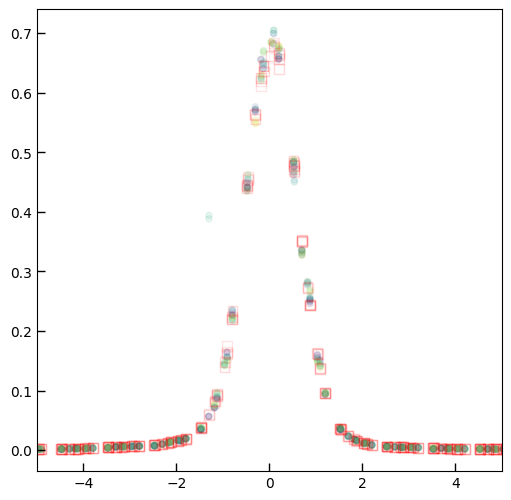

In [11]:
i = 8
wi = wsteps[i]
sub = np.abs(ptab['wave'] - wi) < np.gradient(wsteps)[i]/2
sub &= wht > 0
plt.scatter(ptab['yslit'][sub], (ptab['sci_clean']/spec_norm)[sub], c=ptab['wave'][sub], alpha=0.1, s=80)
plt.scatter(ptab['yslit'][sub], (cprof)[sub], fc='None', ec='r', marker='s', alpha=0.05, s=50) 
plt.xlim(-5,5)

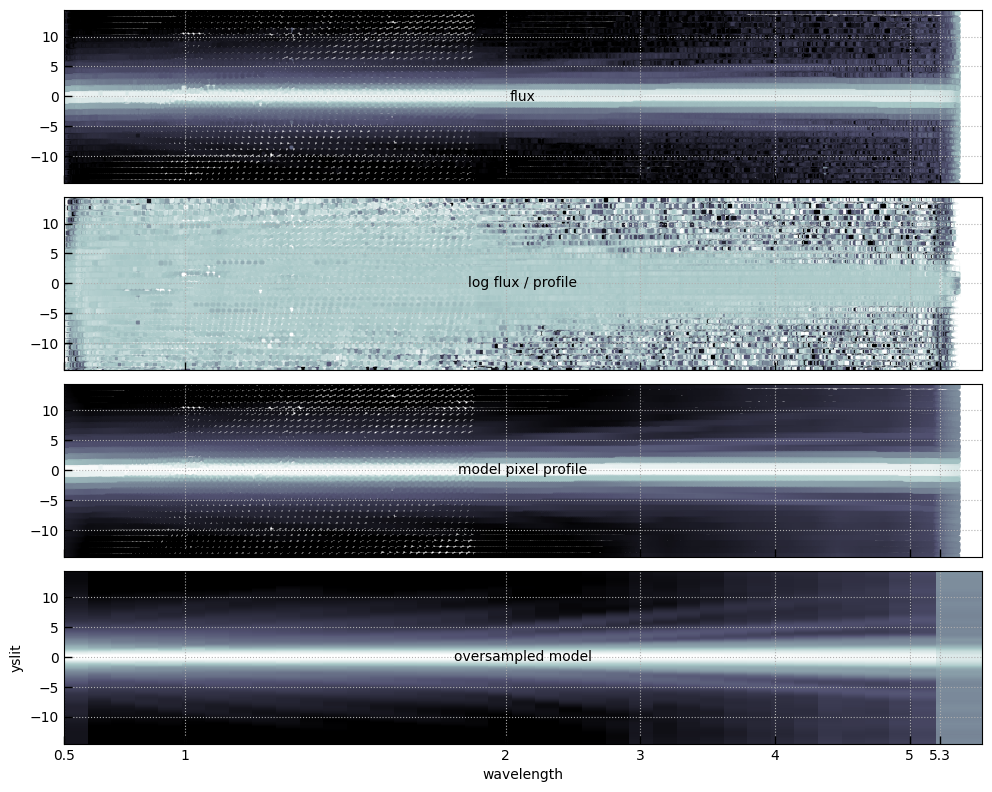

In [12]:
## Oversampled pixels

ystep = 32 # steps per pix
yarr = np.linspace(-8.5,8.5, int(8.5*2*ystep)+1)

yma = yclip
yarr = np.linspace(-yma,yma, int(yma*2*ystep)+1)

xarr = wsteps

xgr, ygr = np.meshgrid(xarr, yarr)

xrange = (-1,1)

xi = np.interp(xgr.flatten(), sp['wave'], np.linspace(*xrange,len(sp['wave'])))
dy = np.polyval(trace_shift_coeffs, xi).flatten()

flat_profs = []
for mi, pwi in zip(pcenters, pwidths):
    pi = PRF(ygr.flatten() + dy, mi, pwi, dx=1.)
    flat_profs.append(pi)

flat_profs = np.array(flat_profs)

fcw = np.array([np.interp(xgr.flatten(), wsteps, coeffs[:,i], left=coeffs[0,i], right=coeffs[-1,i]) for i in range(N)])
fcwn = np.array([np.interp(xgr.flatten(), wsteps, cnorm[:,i], left=cnorm[0,i], right=cnorm[-1,i]) for i in range(N)])
fcprof = (fcw*flat_profs).sum(axis=0)
fcprofn = (fcwn*flat_profs).sum(axis=0)

fig, axes = plt.subplots(4,1,figsize=(10,8), sharex=True, sharey=True)

wmsk = (wht > 0)
# wmsk = ptab['sci_clean']/cprofn > 1000 #np.ones(len(ptab), dtype=bool)

cmap = 'bone'

kws = dict(marker='s', s=3, cmap=cmap)

xst = np.interp(ptab['wave'][wmsk], wsteps, np.arange(len(wsteps)))


axes[0].scatter(xst, ptab['yslit'][wmsk], c=np.log10(ptab['sci_clean']/spec_norm)[wmsk],
                vmin=-4, vmax=0., **kws)

axes[1].scatter(xst, ptab['yslit'][wmsk], c=np.log10(ptab['sci_clean']/spec_norm/cprofn)[wmsk],
                vmin=-1, vmax=0.3, **kws)

axes[2].scatter(xst, ptab['yslit'][wmsk], c=np.log10(cprofn)[wmsk],
                vmin=-4., vmax=-0.2, **kws)

ibins = np.interp(wbins, sp['wave'], np.linspace(0,1,len(sp['wave'])))
ibins = np.arange(len(wsteps))

axes[3].imshow(
    np.log10(fcprofn.reshape(xgr.shape)), vmin=-4., vmax=-0.2,
    aspect='auto',
    extent=(ibins[0], ibins[-1], yarr[0], yarr[-1]),
    cmap=cmap,
)

for ax, label in zip(axes, ['flux', 'log flux / profile', 'model pixel profile', 'oversampled model']):
    ax.text(0.5, 0.5, label, color='k', ha='center', va='center', transform=ax.transAxes)

if 'prism' in ptab_file:
    xt = [0.5, 1, 2, 3, 4, 5, 5.3]
elif 'f100lp' in ptab_file:
    xt = [0.5, 1, 1.2, 1.5, 2, 2.5, 3]
elif 'f070lp' in ptab_file:
    xt = [0.5, 1, 1.2, 1.5, 2, 2.5, 3]
elif 'g235m' in ptab_file:
    xt = [1.5, 2, 2.5, 3.5, 4.0, 4.5, 5.0]
elif 'g395m' in ptab_file:
    xt = [2.5, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

xti = np.interp(xt, wsteps, np.arange(len(wsteps))) #], np.linspace(0,1,len(sp['wave'])))
ax.set_xticks(xti)
ax.set_xticklabels(xt)
            
for ax in axes:
    ax.grid()

# ax.set_ylim(-2.5, 2.5)

ax.set_ylabel('yslit')
ax.set_xlabel('wavelength')

fig.tight_layout(pad=1)


If the model is a good representation of the profile, then the second panel from the top should look flat, which it mostly does with the exception of some minor diffraction spike residuals.

## Make PRF lookup table

Integrate the oversampled profile over the pixel width

In [13]:
x1 = ptab['xint']*(xrange[1] - xrange[0]) + xrange[0]
msk = (xi > x1.min()) & (xi < x1.max())

39it [00:00, 224.70it/s]


skip 0 0.5
skip 37 5.6
skip 38 6.0


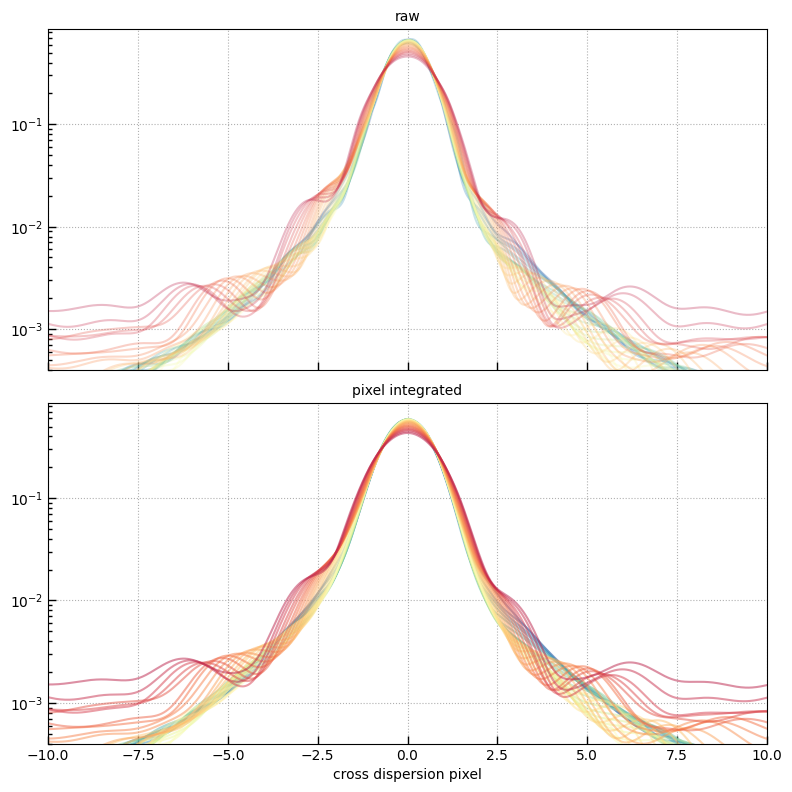

In [14]:
# Integrate over pixels for lookup table
from tqdm import tqdm

ystep2 = ystep//2

yc = yarr[ystep2:-ystep2]
yi = np.arange(len(yarr), dtype=int)[ystep//2:-ystep//2]
nyc = yc.size

pix_prof = np.zeros((nyc, xgr.shape[1]))

fig, axes = plt.subplots(2,1,figsize=(8,8), sharex=True, sharey=True)

slit_frac = wsteps*0.

for k, w in tqdm(enumerate(wsteps)):
    msk2d = msk.reshape(xgr.shape)
    if msk2d[:,k].sum() == 0:
        print('skip', k, wsteps[k])
        continue

    pj = fcprofn.reshape(xgr.shape)[:,k]*1
    ycenter = ((pj*yarr)[np.abs(yarr) < 2.5]).sum() / pj[np.abs(yarr) < 2.5].sum()

    pj = np.interp(yarr + ycenter, yarr, pj)

    axes[0].plot(yarr, pj, color=plt.cm.Spectral_r((k+1)/len(wsteps)), alpha=0.3)
    
    # Integrate over pixels
    
    for i, j in enumerate(yi):
        sl = slice(j-ystep2, j+ystep2+1)
        pix_prof[i,k] = np.trapz(pj[sl], yarr[sl])
    
    axes[1].plot(yc, pix_prof[:,k], alpha=0.5, color=plt.cm.Spectral_r((k+1)/len(wsteps)))

    sk = np.abs(yarr) < 1
    slit_frac[k] = np.trapz(pj[sk], yarr[sk])
    
ax = axes[0]
# ax.set_xlim(-6,6)
ax.set_xlim(-10,10)

axes[0].set_title('raw')
axes[1].set_title('pixel integrated')

ax.semilogy()

#ax.set_xlim(-5,5)
for ax in axes:
    ax.grid()

ax.set_xlabel('cross dispersion pixel')
ax.set_ylim(4.e-4, 0.85)

fig.tight_layout(pad=1)

valid = pix_prof.sum(axis=0) > 0

pix_prof_wave = wsteps*1
pix_prof_wavei = np.arange(len(pix_prof_wave))

pix_prof_y = yc
pix_prof_yi = np.arange(len(pix_prof_y))

# pix_prof[:,0] = pix_prof[:,1]*1
# pix_prof[:,-1] = pix_prof[:,-2]*1

# slit_frac[0] = slit_frac[1]
# slit_frac[-1] = slit_frac[-2]



## Convolve with intrinsic Gaussian / Exponential profiles with a grid of widths

Precompute a grid of profiles where an intrinsic profile is convolved with the PSF and then integrated over pixels.

39it [00:05,  7.39it/s]


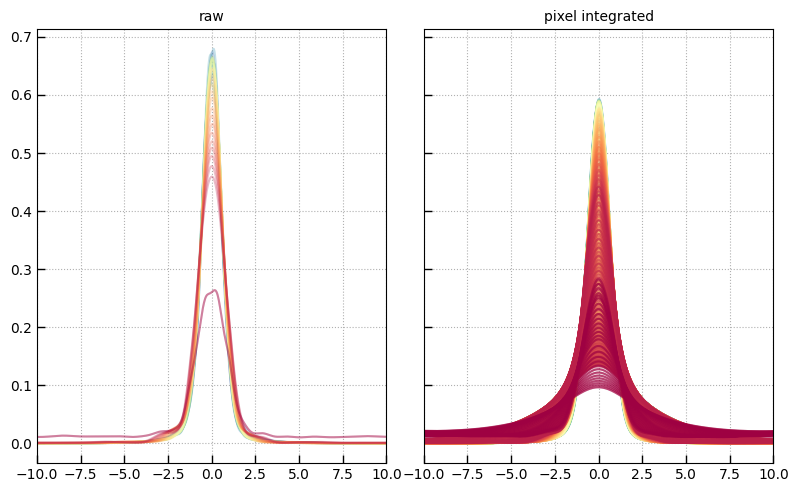

In [15]:
k = 10
pj = fcprofn.reshape(xgr.shape)[:,k]*1
# plt.plot(yarr, pj, color=plt.cm.Spectral_r((k+1)/len(wsteps)), alpha=0.5)

import scipy.ndimage as nd

dy = np.diff(yarr)[0]

xgau = np.arange(-12.5, 12.5, dy)
# xgau = yarr*1.

gsteps = np.append(0.0, np.logspace(-1, np.log10(2), 16))
# gsteps = np.append(0.0, np.logspace(np.log10(0.05), np.log10(2), 21))
# gsteps = np.linspace(0, 2, 21)

gsteps = np.linspace(0, 0.5, 11)
gsteps = np.append(np.arange(0, 0.7, 0.05), np.arange(0.7, 2.01, 0.1))


ystep2 = ystep//2
# ystep2 = int(ystep//3)

yc = xgau[ystep2:-ystep2]
yi = np.arange(len(xgau), dtype=int)[ystep//2:-ystep//2]
nyc = yc.size

pix_prof = np.zeros((nyc, len(wsteps), len(gsteps)))

fig, axes = plt.subplots(1,2,figsize=(8,5), sharex=True, sharey=True)

# source x offset goes from (-0.5, 0.5) corresponding to (-1, 1) pixels

slit_loss_steps = np.linspace(0,0.5,16)
slit_frac = np.zeros((len(wsteps), len(gsteps), len(slit_loss_steps)))

for k, w in tqdm(enumerate(wsteps)):
    # msk2d = msk.reshape(xgr.shape)
    # if msk2d[:,k].sum() == 0:
    #     print('skip', k, wsteps[k])
    #     continue

    pj = fcprofn.reshape(xgr.shape)[:,k]*1
    
    ycenter = ((pj*yarr)[np.abs(yarr) < 2.5]).sum() / pj[np.abs(yarr) < 2.5].sum()

    pj = np.interp(yarr + ycenter, yarr, pj)
    
    # ycenter = (pj*yarr).sum() / pj.sum()
    # print('xx', k, w, ycenter)

    axes[0].plot(yarr, pj, color=plt.cm.Spectral_r((k+1)/len(wsteps)), alpha=0.3)
    
    # Integrate over pixels
    for gi, gw in enumerate(gsteps):
        if gw == 0:
            conv = np.interp(xgau, yarr, pj, left=0, right=0)
        else:
                        
            if 1:
                # Exponential
                prof_type = 'exp'
                gau = 1./2 * np.log(2) / gw * np.exp(-np.abs(xgau) / gw * np.log(2))
            else:
                # Gaussian
                prof_type = 'gau'
                gau = 1/np.sqrt(2*np.pi*gw**2)*np.exp(-xgau**2/2/gw**2)

            conv = nd.convolve1d(gau, pj/pj.sum())

        # print(gi, gw, np.trapz(gau, xgau), np.trapz(pj, yarr))
        # conv /= np.trapz(conv, xgau)
        
        for i, j in enumerate(yi):
            sl = slice(j-ystep2, j+ystep2+1)
            pix_prof[i,k,gi] = np.trapz(conv[sl], xgau[sl])

        # pix_prof[:,k,gi] = conv[ystep2:-ystep2]
        
        axes[1].plot(yc, pix_prof[:,k,gi], alpha=0.5, color=plt.cm.Spectral_r((k+1)/len(wsteps)))
    
        for sli in range(len(slit_loss_steps)):
            
            sk = np.abs(xgau - slit_loss_steps[sli]*2) < 1
            slit_frac[k,gi,sli] = np.trapz(conv[sk], xgau[sk])
    
ax = axes[0]
ax.set_xlim(-6,6)
ax.set_xlim(-10,10)

axes[0].set_title('raw')
axes[1].set_title('pixel integrated')

#ax.set_xlim(-5,5)
for ax in axes:
    ax.grid()

fig.tight_layout(pad=1)

valid = pix_prof.sum(axis=0) > 0

pix_prof_wave = wsteps*1
pix_prof_wavei = np.arange(len(pix_prof_wave))

pix_prof_y = yc
pix_prof_yi = np.arange(len(pix_prof_y))

pix_prof_g = gsteps

# pix_prof[:,0,:] = pix_prof[:,1,:]*1
# pix_prof[:,-1,:] = pix_prof[:,-2,:]*1

# slit_frac[0,:] = slit_frac[1,:]
# slit_frac[-1,:] = slit_frac[-2,:]

## Path loss

The path loss is calibrated relative to a centered point source because that is how the throughput is defined.

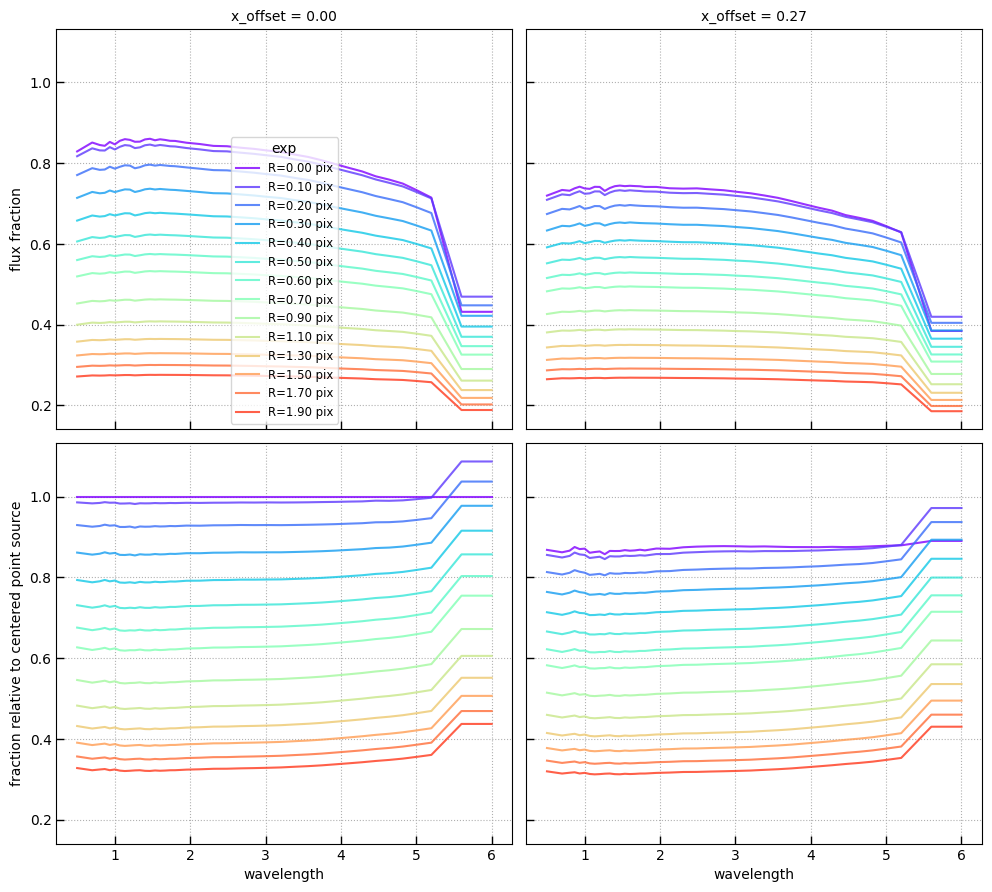

In [16]:
fig, axes = plt.subplots(2,2,figsize=(10,9), sharex=True, sharey=True)

for i, ioff in enumerate([0, 8]):
    ax = axes[0][i]
    ax2 = axes[1][i]
    for j in range(len(gsteps))[::2]:
        ax.plot(wsteps, slit_frac[:,j,ioff] / slit_frac[:,0,0]**0,
                alpha=0.8, color=plt.cm.rainbow(j/len(gsteps)),
                label = f'R={gsteps[j]:.2f} pix'
               )

        ax2.plot(wsteps, slit_frac[:,j,ioff] / slit_frac[:,0,0]**1,
                alpha=0.8, color=plt.cm.rainbow(j/len(gsteps)),
                label = f'R={gsteps[j]:.2f} pix'
               )

    ax.grid()
    ax2.grid()
    
    ax2.set_xlabel('wavelength')
    ax.set_title(f'x_offset = {slit_loss_steps[ioff]:.2f}')

leg = axes[0][0].legend(loc='lower center')
leg.set_title(prof_type)

axes[0][0].set_ylabel('flux fraction')
axes[1][0].set_ylabel('fraction relative to centered point source')

fig.tight_layout(pad=1)


### Write the lookup table file

In [17]:
key = f"{sp.meta['GRATING']}_{sp.meta['FILTER']}".lower()

In [18]:
import astropy.io.fits as pyfits

hdul = pyfits.HDUList([
    pyfits.PrimaryHDU(), 
    pyfits.ImageHDU(data=pix_prof, name='PROF'),
    pyfits.ImageHDU(data=pix_prof_y, name='YSLIT'),
    pyfits.ImageHDU(data=pix_prof_wave, name='WAVE'),
    pyfits.ImageHDU(data=pix_prof_g, name='SIGMA'),
    pyfits.ImageHDU(data=slit_loss_steps, name='LOSS_XOFFSET'),
    pyfits.ImageHDU(data=slit_frac, name='LOSS')
])

hdul['WAVE'].header['BUNIT'] = 'micron'
hdul.info()

lookup_file = f'nirspec_{key}_{prof_type}_psf_lookup.fits'
print(lookup_file)

hdul.writeto(lookup_file, overwrite=True, output_verify='fix')

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PROF          1 ImageHDU         9   (28, 39, 768)   float64   
  2  YSLIT         1 ImageHDU         7   (768,)   float64   
  3  WAVE          1 ImageHDU         8   (39,)   float64   
  4  SIGMA         1 ImageHDU         7   (28,)   float64   
  5  LOSS_XOFFSET    1 ImageHDU         7   (16,)   float64   
  6  LOSS          1 ImageHDU         9   (16, 28, 39)   float64   
nirspec_prism_clear_exp_psf_lookup.fits
